In [9]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

In [30]:
# Load data
df = pd.read_csv('burlington_bands_shows.csv')
df['venue'] = df['venue'].str.replace('-', 'Unknown Venue')
print(df.head(20))


          date                                bands                   venue  \
0    5/15/2021                           No Showers               Dartmouth   
1     7/3/2021                           No Showers                     Tub   
2    7/10/2021       All Night Boogie Band, rudolph                    hous   
3    7/16/2021                           No Showers                     Tub   
4     8/7/2021                           No Showers                     Tub   
5    8/27/2021                           No Showers                     Tub   
6     9/3/2021                           No Showers          Redstone Green   
7    9/10/2021                              Rudolph                     Tub   
8    9/11/2021                           No Showers                Orlandos   
9    9/18/2021                           No Showers              Middlebury   
10   9/24/2021                           No Showers  Dartmouth (Bones Gate)   
11   10/8/2021                           No Showers 

In [31]:

# Create bipartite graph with two node sets: bands and venue
G = nx.Graph()
# Iterate over each row of the dataframe
for i, row in df.iterrows():
    
    # Split the bands column by comma to handle multiple bands
    bands = row['bands'].split(', ')
    venue = row['venue']
    
    # Add edges between venue and bands
    for band in bands:
        # Add venue node to graph if not already present
        if not G.has_node(venue):
            G.add_node(venue, bipartite=0)
        # Add band node to graph if not already present
        if not G.has_node(band):
            G.add_node(band, bipartite=1)
        # Add edge between venue and band with weight equal to number of shows played
        if G.has_edge(venue, band):
            G[venue][band]['weight'] += 1
        else:
            G.add_edge(venue, band, weight=1)
    
    # Add edges between bands
    for j in range(len(bands)):
        for k in range(j+1, len(bands)):
            # Add edges between bands with weight equal to number of shows played together
            if G.has_edge(bands[j], bands[k]):
                G[bands[j]][bands[k]]['weight'] += 1
            else:
                G.add_edge(bands[j], bands[k], weight=1)
                
# Print number of nodes and edges in the graph
print(nx.info(G))



Graph with 141 nodes and 283 edges


C:\Users\alexp\AppData\Local\Temp\ipykernel_21316\1159136960.py:34: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  print(nx.info(G))


### bipartite visualization function that takes in the bipartite graph and plots it with nodes colored by their bipartite membership (either 'bands' or 'venues') and edge weights proportional to the number of co-appearances or shows at a venue

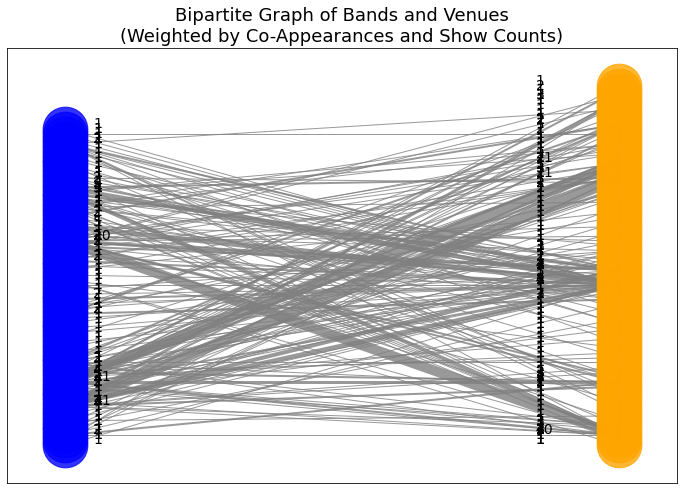

In [37]:
import matplotlib.pyplot as plt
import networkx as nx

def plot_bipartite(G):
    # Get sets of bands and venues nodes
    bands = {n for n, d in G.nodes(data=True) if d['bipartite'] == 0}
    venues = set(G) - bands

    # Set positions for bands and venues
    pos = dict()
    pos.update((node, (1, index)) for index, node in enumerate(bands))
    pos.update((node, (2, index)) for index, node in enumerate(venues))

    # Get weights for edges between bands and venues
    band_counts = dict()
    for band, venue in G.edges(bands):
        if band not in band_counts:
            band_counts[band] = dict()
        if venue not in band_counts[band]:
            band_counts[band][venue] = 0
        band_counts[band][venue] += G[band][venue]['weight']
    venue_counts = dict()
    for venue, band in G.edges(venues):
        if venue not in venue_counts:
            venue_counts[venue] = dict()
        if band not in venue_counts[venue]:
            venue_counts[venue][band] = 0
        venue_counts[venue][band] += G[venue][band]['weight']

    # Draw graph
    plt.figure(figsize=(12,8))
    nx.draw_networkx_nodes(G, pos, nodelist=bands, node_size=2000, node_color='blue', alpha=0.8)
    nx.draw_networkx_nodes(G, pos, nodelist=venues, node_size=2000, node_color='orange', alpha=0.8)
    nx.draw_networkx_edges(G, pos, edgelist=G.edges(), edge_color='grey', alpha=0.8, width=[G[u][v]['weight'] for u,v in G.edges()])
    for band, counts in band_counts.items():
        for venue, count in counts.items():
            plt.text(pos[band][0] + 0.05, pos[band][1] + 0.2, s=count, fontsize=14)
    for venue, counts in venue_counts.items():
        for band, count in counts.items():
            plt.text(pos[venue][0] - 0.15, pos[venue][1] + 0.2, s=count, fontsize=14)
    plt.title('Bipartite Graph of Bands and Venues\n(Weighted by Co-Appearances and Show Counts)', fontsize=18)
    plt.xticks([])
    plt.yticks([])
    plt.show()
plot_bipartite(G)

In [33]:
# Create the co-appearance matrix
co_appearance_matrix = np.zeros((len(bands), len(bands)))

# Loop through each venue and update the co-appearance matrix
for venue in venue:
    bands_at_venue = [node for node in G[venue] if node in bands]
    for i in range(len(bands_at_venue)):
        for j in range(i+1, len(bands_at_venue)):
            band1 = bands.index(bands_at_venue[i])
            band2 = bands.index(bands_at_venue[j])
            co_appearance_matrix[band1][band2] += 1
            co_appearance_matrix[band2][band1] += 1

# Print the co-appearance matrix
print(co_appearance_matrix)

KeyError: 'W'

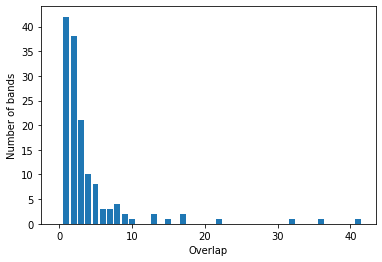

In [34]:

degrees = [G.degree(n) for n in G.nodes()]
plt.hist(degrees, bins=np.arange(max(degrees)+2)-0.5, rwidth=0.8)
plt.xlabel('Overlap')
plt.ylabel('Number of bands')
plt.show()